In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import re 
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.pipeline import make_pipeline
from sklearn.datasets import make_blobs

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score

from sklearn.utils import shuffle

In [2]:
os.getcwd()
pd.set_option('display.max_columns', 100)

In [3]:
#download data for genuine users

df_gen_users = pd.read_csv('datasets_full.csv/genuine_accounts.csv/users.csv')

#define columns to keep for investigation

columns_to_keep = ['id', 'name', 'screen_name', 'statuses_count', 'followers_count',
       'friends_count', 'favourites_count', 'listed_count', 'url', 'lang',
       'time_zone', 'location', 'default_profile', 'default_profile_image',
       'geo_enabled', 'profile_image_url', 'profile_banner_url',
       'profile_use_background_image', 'profile_background_image_url_https',
       'profile_text_color', 'profile_image_url_https','follow_request_sent', 
       'verified','description', 'following']

# trim the bot data and add a binary column = 1 to indicate that this data is human data

df_gen_users = df_gen_users[columns_to_keep]
df_gen_users['bot'] = 0

In [4]:
# download data for traditional bots for training purpose
# use trad_bot_1 since it was the main focus of the 'traditional model'

df_trad_bot1_users = pd.read_csv('datasets_full.csv/traditional_spambots_1.csv/users.csv')

# trim the bot data and add a binary column = 1 to indicate that this data is bot data
df_trad_bot1_users = df_trad_bot1_users[columns_to_keep]
df_trad_bot1_users['bot'] = 1

In [5]:
# split the genuine data into training set and test set to avoid overlap

df_gen_train, df_gen_test = train_test_split(df_gen_users, test_size = 0.5, shuffle = True)

In [6]:
#create training dataset by concatenating the training split of genuine data and trad_bot_1 data

df_train = pd.concat([df_gen_train.sample(len(df_trad_bot1_users)), df_trad_bot1_users])
df_train = shuffle(df_train)

In [7]:
# Create the test set
# Use social spambots #1 and social spambots #3 as two separate test data set

df_test_bot1_users = pd.read_csv('datasets_full.csv/social_spambots_1.csv/users.csv')
df_test_bot3_users = pd.read_csv('datasets_full.csv/social_spambots_3.csv/users.csv')

df_test_bot1_users = df_test_bot1_users[columns_to_keep]
df_test_bot1_users['bot'] = 1

df_test_bot3_users = df_test_bot3_users[columns_to_keep]
df_test_bot3_users['bot'] = 1

#create test set with 50% genuine data, and 50% social spambot data

df_test_1 = pd.concat([df_gen_test.sample(len(df_test_bot1_users), random_state= 1), df_test_bot1_users])
df_test_3 = pd.concat([df_gen_test.sample(len(df_test_bot3_users), random_state= 1), df_test_bot3_users])

df_test_1 = shuffle(df_test_1)
df_test_3 = shuffle(df_test_3)

In [8]:
#define data cleaning functions

#cleaning step 1: check if screen_name has a word 'bot' in it

def screen_name_check (df):
    
    word = 'bot'
    bot_name = []
    k = 0

    for i in range (len(df)):
        if pd.isnull(df.iloc[i,:]['screen_name']):
                k = 0
        else: 
            if word in df.iloc[i,:]['screen_name']:
                k = 1
            else:
                k = 0
        bot_name.append(k)
    
    return bot_name


#cleaning step 2: check if location parameter is present

def location_check(df):
    
    loc = []

    for i in range (len(df)):
        if pd.isnull(df.iloc[i,:]['location']):
            loc.append(0)
        else:
            loc.append(1)
            
    return loc

# cleaning step 3
# Set description to 1 if it contains either of these words: 
#‘bot’, ‘robot’, ‘artificial’, ‘intelligence’, ‘neural’, ‘network’, ‘automatic’ and 0 otherwise.

def description_check(df):
    keyword = ['bot', 'robot', 'artificial', 'intelligence', 'neural', 'network', 'automatic']
    bot_des = []
    k = 0

    for i in range (len(df)):
        for keyword in keyword:
            if pd.isnull(df.iloc[i,:]['description']):
                k = 0
            else:
                if df.iloc[i,:]['description'].find(keyword) == -1:
                    k = 0
                else:
                    k = 1
        bot_des.append(k)
        
    return bot_des

#cleaning step 4:
#Set verified to 1 if the sample’s verified features contents are True and 0 otherwise.

def verified_check(df):
    ver = []

    for i in range (len(df)):
        if pd.isnull(df.iloc[i,:]['verified']):
            ver.append(0)
        else:
            ver.append(1)
    return ver

#cleaning step 5:
#Check if default profile exists or not.

def default_profile_check (df):
    
    default_profile = []

    for i in range (len(df)):
        if pd.isnull(df.iloc[i,:]['default_profile']):
            default_profile.append(0)
        else:
            default_profile.append(1)
    
    return default_profile

#cleaning step 6:
#Check if default profile image is used or not.

def default_image_check (df):
    
    default_profile_image = []

    for i in range (len(df)):
        if pd.isnull(df.iloc[i,:]['default_profile_image']):
            default_profile_image.append(0)
        else:
            default_profile_image.append(1)
    
    return default_profile_image

In [9]:
def master_clean (df):
    bot_name = screen_name_check (df)
    loc = location_check (df)
    bot_des = description_check (df)
    ver = verified_check (df)
    default_profile = default_profile_check (df)
    default_profile_image = default_image_check (df)
    
    df = pd.DataFrame({'screen_name': df['screen_name'],
                       'name': df['name'],
                       'id': df['id'],
                       'bot_in_name':bot_name,
                       'bot_in_des':bot_des,
                       'location': loc,
                       'verified': ver,
                       'default_profile': default_profile,
                       'default_profile_image': default_profile_image,
                       'followers_count': df['followers_count'],
                       'listed_count': df['listed_count'],
                       'friends_count': df['friends_count'],
                       'favourites_count': df['favourites_count'],
                       'statuses_count': df['statuses_count'],
                       'bot_or_not':df['bot']
                       })
    
    return df

In [10]:
#apply the cleaning function to training set and testing set

df_train = master_clean(df_train)
df_test_1 = master_clean(df_test_1)
df_test_3 = master_clean(df_test_3)

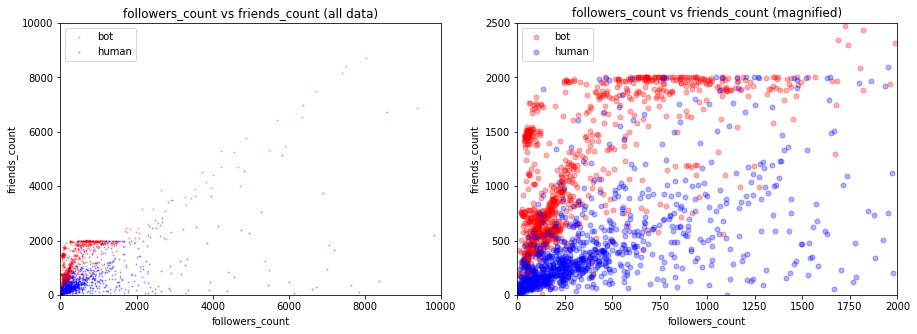

In [50]:
#explore training dataset

df = df_train

fig, ax = plt.subplots(1,2, figsize = (15, 5))
alpha = 0.3
markersize = 1

ax[0].plot(df[df['bot_or_not']==1]['followers_count'],
         df[df['bot_or_not']==1]['friends_count'],
         'o', color = 'red', markersize = markersize, alpha = alpha, label = 'bot')

ax[0].plot(df[df['bot_or_not']==0]['followers_count'],
         df[df['bot_or_not']==0]['friends_count'],
         'o', color = 'blue',markersize = markersize, alpha = alpha, label = 'human')
ax[0].set_xlabel('followers_count')
ax[0].set_ylabel('friends_count')
ax[0].set_xlim((0, 10000))
ax[0].set_ylim((0, 10000))
ax[0].set_title('followers_count vs friends_count (all data)')
ax[0].legend()


ax[1].plot(df[df['bot_or_not']==1]['followers_count'],
         df[df['bot_or_not']==1]['friends_count'],
         'o', color = 'red', markersize = 5, alpha = alpha, label = 'bot')

ax[1].plot(df[df['bot_or_not']==0]['followers_count'],
         df[df['bot_or_not']==0]['friends_count'],
         'o', color = 'blue',markersize = 5, alpha = alpha, label = 'human')
ax[1].set_xlabel('followers_count')
ax[1].set_ylabel('friends_count')
ax[1].set_xlim((0, 2000))
ax[1].set_ylim((0, 2500))
ax[1].set_title('followers_count vs friends_count (magnified)')
ax[1].legend()

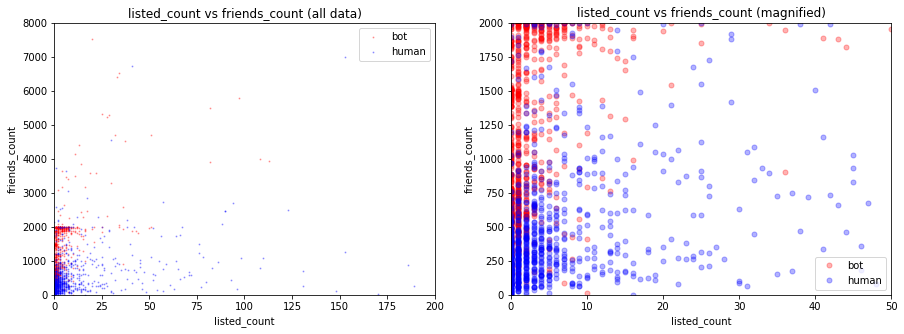

In [59]:
df = df_train

fig, ax = plt.subplots(1,2, figsize = (15, 5))
alpha = 0.3
markersize = 1

ax[0].plot(df[df['bot_or_not']==1]['listed_count'],
         df[df['bot_or_not']==1]['friends_count'],
         'o', color = 'red', markersize = markersize, alpha = alpha, label = 'bot')

ax[0].plot(df[df['bot_or_not']==0]['listed_count'],
         df[df['bot_or_not']==0]['friends_count'],
         'o', color = 'blue',markersize = markersize, alpha = alpha, label = 'human')
ax[0].set_xlabel('listed_count')
ax[0].set_ylabel('friends_count')
ax[0].set_xlim((0, 200))
ax[0].set_ylim((0, 8000))
ax[0].set_title('listed_count vs friends_count (all data)')
ax[0].legend()


ax[1].plot(df[df['bot_or_not']==1]['listed_count'],
         df[df['bot_or_not']==1]['friends_count'],
         'o', color = 'red', markersize = 5, alpha = alpha, label = 'bot')

ax[1].plot(df[df['bot_or_not']==0]['listed_count'],
         df[df['bot_or_not']==0]['friends_count'],
         'o', color = 'blue',markersize = 5, alpha = alpha, label = 'human')
ax[1].set_xlabel('listed_count')
ax[1].set_ylabel('friends_count')
ax[1].set_xlim((0, 50))
ax[1].set_ylim((0, 2000))
ax[1].set_title('listed_count vs friends_count (magnified)')
ax[1].legend()

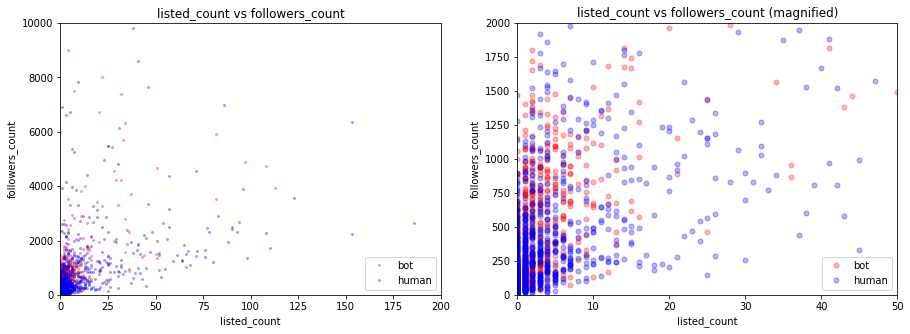

In [74]:
df = df_train
var1 = 'listed_count'
var2 = 'followers_count'

fig, ax = plt.subplots(1,2, figsize = (15, 5))
alpha = 0.3
markersize = 2

ax[0].plot(df[df['bot_or_not']==1][var1],
         df[df['bot_or_not']==1][var2],
         'o', color = 'red', markersize = markersize, alpha = alpha, label = 'bot')

ax[0].plot(df[df['bot_or_not']==0][var1],
         df[df['bot_or_not']==0][var2],
         'o', color = 'blue',markersize = markersize, alpha = alpha, label = 'human')
ax[0].set_xlabel(var1)
ax[0].set_ylabel(var2)
ax[0].set_xlim((0, 200))
ax[0].set_ylim((0, 10000))
ax[0].set_title('')
ax[0].set_title('listed_count vs followers_count')
ax[0].legend()

ax[1].plot(df[df['bot_or_not']==1][var1],
         df[df['bot_or_not']==1][var2],
         'o', color = 'red', markersize = 5, alpha = alpha, label = 'bot')

ax[1].plot(df[df['bot_or_not']==0][var1],
         df[df['bot_or_not']==0][var2],
         'o', color = 'blue',markersize = 5, alpha = alpha, label = 'human')
ax[1].set_xlabel(var1)
ax[1].set_ylabel(var2)
ax[1].set_xlim((0, 50))
ax[1].set_ylim((0, 2000))
ax[1].set_title('')
ax[1].set_title('listed_count vs followers_count (magnified)')
ax[1].legend()

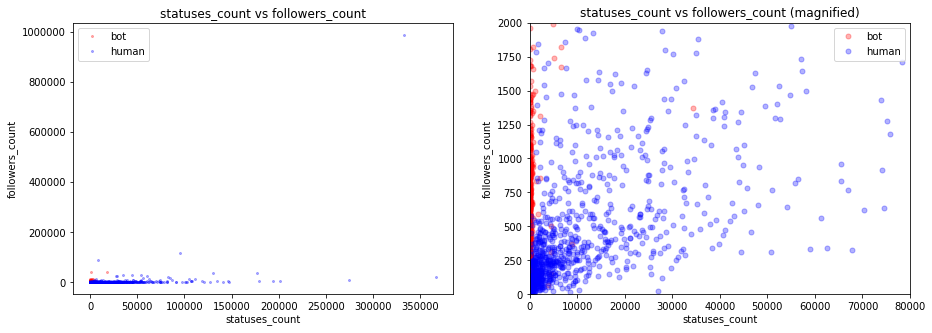

In [77]:
df = df_train
var1 = 'statuses_count'
var2 = 'followers_count'

fig, ax = plt.subplots(1,2, figsize = (15, 5))
alpha = 0.3
markersize = 2

ax[0].plot(df[df['bot_or_not']==1][var1],
         df[df['bot_or_not']==1][var2],
         'o', color = 'red', markersize = markersize, alpha = alpha, label = 'bot')

ax[0].plot(df[df['bot_or_not']==0][var1],
         df[df['bot_or_not']==0][var2],
         'o', color = 'blue',markersize = markersize, alpha = alpha, label = 'human')
ax[0].set_xlabel(var1)
ax[0].set_ylabel(var2)
ax[0].set_xlim()
ax[0].set_ylim()
ax[0].set_title('')
ax[0].set_title('statuses_count vs followers_count')
ax[0].legend()

ax[1].plot(df[df['bot_or_not']==1][var1],
         df[df['bot_or_not']==1][var2],
         'o', color = 'red', markersize = 5, alpha = alpha, label = 'bot')

ax[1].plot(df[df['bot_or_not']==0][var1],
         df[df['bot_or_not']==0][var2],
         'o', color = 'blue',markersize = 5, alpha = alpha, label = 'human')
ax[1].set_xlabel(var1)
ax[1].set_ylabel(var2)
ax[1].set_xlim((0, 80000))
ax[1].set_ylim((0, 2000))
ax[1].set_title('')
ax[1].set_title('statuses_count vs followers_count (magnified)')
ax[1].legend()

Text(0.5,1,'favourites_count')

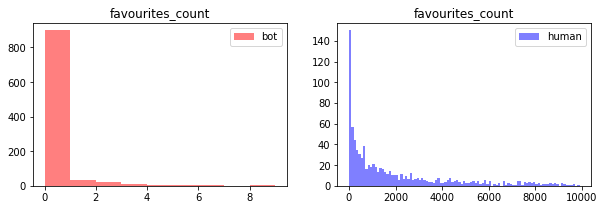

In [13]:
df = df_train

fig, ax = plt.subplots(1,2, figsize = (10, 3))
size = 0.5
alpha = 0.5

var1 = 'favourites_count'

ax[0].hist(df[df['bot_or_not']==1][var1],color = 'red',  alpha = alpha, label = 'bot',
           bins =np.arange(0, 10, 1))

ax[0].legend()

ax[1].hist(df[df['bot_or_not']==0][var1],color = 'blue', alpha = alpha, label = 'human',
          bins = np.arange(0, 10000, 100))
ax[1].legend()

ax[0].set_title(var1)
ax[1].set_title(var1)

Text(0.5,1,'friends_count')

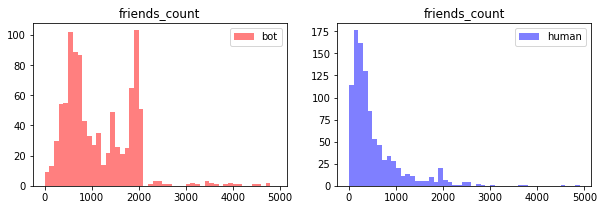

In [14]:
df = df_train

fig, ax = plt.subplots(1,2, figsize = (10, 3))
size = 0.5
alpha = 0.5

var2 = 'friends_count'

ax[0].hist(df[df['bot_or_not']==1][var2],color = 'red',  alpha = alpha, label = 'bot',
           bins =np.arange(0, 5000, 100))
ax[0].legend()

ax[1].hist(df[df['bot_or_not']==0][var2],color = 'blue', alpha = alpha, label = 'human',
          bins = np.arange(0, 5000, 100))
ax[1].legend()

ax[0].set_title(var2)
ax[1].set_title(var2)

Text(0.5,1,'followers_count')

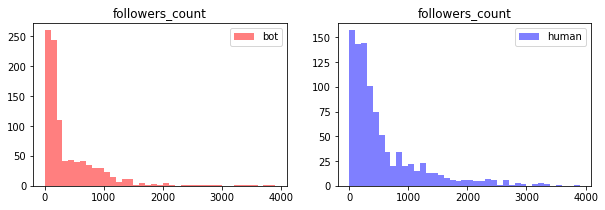

In [15]:
df = df_train


fig, ax = plt.subplots(1,2, figsize = (10, 3))
size = 0.5
alpha = 0.5

var1 = 'followers_count'

ax[0].hist(df[df['bot_or_not']==1][var1],color = 'red',  alpha = alpha, label = 'bot',
           bins =np.arange(0, 4000, 100))

ax[0].legend()
ax[1].hist(df[df['bot_or_not']==0][var1],color = 'blue', alpha = alpha, label = 'human',
          bins = np.arange(0, 4000, 100))
ax[1].legend()

ax[0].set_title(var1)
ax[1].set_title(var1)

Text(0.5,1,'listed_count')

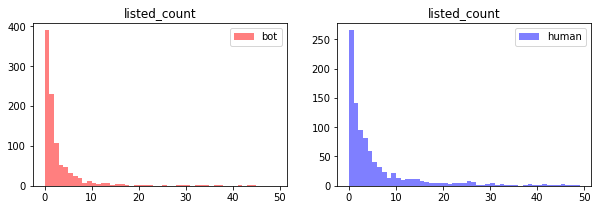

In [16]:
df = df_train


fig, ax = plt.subplots(1,2, figsize = (10, 3))
size = 0.5
alpha = 0.5

var1 = 'listed_count'

ax[0].hist(df[df['bot_or_not']==1][var1],color = 'red',  alpha = alpha, label = 'bot',
           bins =np.arange(0, 50, 1))

ax[0].legend()
ax[1].hist(df[df['bot_or_not']==0][var1],color = 'blue', alpha = alpha, label = 'human',
          bins = np.arange(0, 50, 1))
ax[1].legend()

ax[0].set_title(var1)
ax[1].set_title(var1)

Text(0.5,1,'statuses_count')

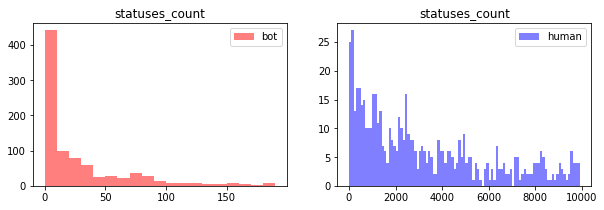

In [17]:
df = df_train

fig, ax = plt.subplots(1,2, figsize = (10, 3))
size = 0.5
alpha = 0.5

var1 = 'statuses_count'

ax[0].hist(df[df['bot_or_not']==1][var1],color = 'red',  alpha = alpha, label = 'bot',
           bins =np.arange(0, 200, 10))

ax[0].legend()
ax[1].hist(df[df['bot_or_not']==0][var1],color = 'blue', alpha = alpha, label = 'human',
          bins = np.arange(0, 10000, 100))
ax[1].legend()

ax[0].set_title(var1)
ax[1].set_title(var1)

In [18]:
#Prepare dataset to feed into the model

# X_train from df_train
X_train = df_train.drop(columns=['bot_or_not', 'screen_name', 'name', 'id'])

# y_trian from df_train
y_train = df_train[['bot_or_not']]

# X_test_1 from df_test_1
X_test_1 = df_test_1.drop(columns=['bot_or_not', 'screen_name', 'name', 'id'])

# y_test_1 from df_test_1
y_test_1 = df_test_1[['bot_or_not']]

# X_test_3 from df_test_3
X_test_3 = df_test_3.drop(columns=['bot_or_not', 'screen_name', 'name', 'id'])

# y_test_3 from df_test_3
y_test_3 = df_test_3[['bot_or_not']]

In [19]:
# Simple Decision Tree

decision_model = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=3)
decision_model.fit(X_train, y_train)

y_pred_train_dec = decision_model.predict(X_train)

y_pred_test_1_dec = decision_model.predict(X_test_1)
y_pred_test_3_dec = decision_model.predict(X_test_3)

train_score_dec = accuracy_score(y_train, y_pred_train_dec) * 100

test_score_1_dec = accuracy_score(y_test_1, y_pred_test_1_dec) * 100
test_score_3_dec = accuracy_score(y_test_3, y_pred_test_3_dec) * 100

print('accuracy score of the training set is {}%'.format(train_score_dec))
print('accuracy score of the test set with social spambot #1 is {}%'.format(test_score_1_dec))
print('accuracy score of the test set with social spambot #3 is {}%'.format(test_score_3_dec))


accuracy score of the training set is 98.9%
accuracy score of the test set with social spambot #1 is 69.87891019172552%
accuracy score of the test set with social spambot #3 is 77.69396551724138%


In [20]:
depth = np.arange(2,15,1)
decision_score_mean=[]
decision_score_std=[]
test_1_score = []
test_3_score = []

for i in depth:
    decision_model = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=i)
    decision_model.fit(X_train, y_train)
    score = cross_val_score(estimator = decision_model, X = X_train, y = y_train, cv = 5)
    decision_score_mean.append(score.mean())
    decision_score_std.append(score.std())
    test_1_score.append(accuracy_score(y_test_1, decision_model.predict(X_test_1)))
    test_3_score.append(accuracy_score(y_test_3, decision_model.predict(X_test_3)))

Text(0,0.5,'test set accuracy score')

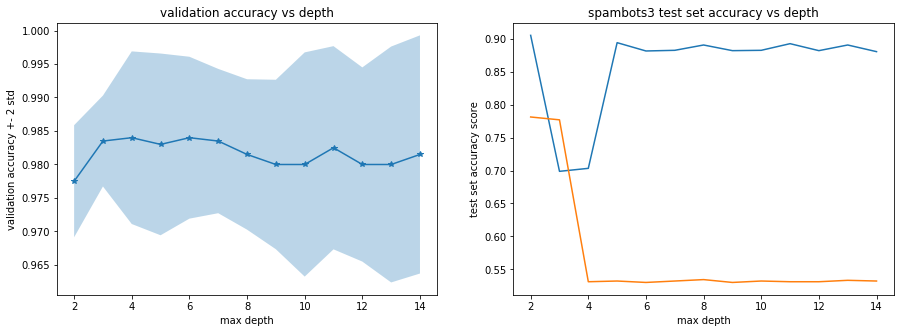

In [21]:
fig, ax = plt.subplots(1,2, figsize = (15,5))

ax[0].plot(depth, decision_score_mean, '-*')
ax[0].fill_between(
    depth,
    np.array(decision_score_mean) - 2 * np.array(decision_score_std),
    np.array(decision_score_mean) + 2 * np.array(decision_score_std),
    alpha=.3)
ax[0].set_title('validation accuracy vs depth')
ax[0].set_xlabel('max depth')
ax[0].set_ylabel('validation accuracy +- 2 std')

ax[1].plot(depth, test_1_score)
ax[1].plot(depth, test_3_score)
ax[1].set_title('spambots3 test set accuracy vs depth')
ax[1].set_xlabel('max depth')
ax[1].set_ylabel('test set accuracy score')

In [22]:
overfit_depth = 100
N = 100

bagging_model = BaggingClassifier(DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=overfit_depth), 
                                  n_estimators = N, bootstrap = True, oob_score = True)
bagging_model.fit(X_train, y_train)

y_pred_train_bag = bagging_model.predict(X_train)

y_pred_test_1_bag = bagging_model.predict(X_test_1)
y_pred_test_3_bag = bagging_model.predict(X_test_3)

train_score_bag = accuracy_score(y_train, y_pred_train_bag) * 100

test_score_1_bag = accuracy_score(y_test_1, y_pred_test_1_bag) * 100
test_score_3_bag = accuracy_score(y_test_3, y_pred_test_3_bag) * 100

print('accuracy score of the training set is {}%'.format(train_score_bag))
print('accuracy score of the test set with social spambot #1 is {}%'.format(test_score_1_bag))
print('accuracy score of the test set with social spambot #3 is {}%'.format(test_score_3_bag))

C:\Users\motoa\Anaconda3\lib\site-packages\sklearn\ensemble\bagging.py:618: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


accuracy score of the training set is 100.0%
accuracy score of the test set with social spambot #1 is 84.81331987891019%
accuracy score of the test set with social spambot #3 is 54.418103448275865%


In [93]:
ada_model = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3),  
                               n_estimators=800, learning_rate=0.05)

ada_model.fit(X_train, y_train)

y_pred_train_ada = ada_model.predict(X_train)
y_pred_test_1_ada = ada_model.predict(X_test_1)
y_pred_test_3_ada = ada_model.predict(X_test_3)


train_score_ada = accuracy_score(y_train, y_pred_train_ada) * 100
test_score_1_ada = accuracy_score(y_test_1, y_pred_test_1_ada) * 100
test_score_3_ada = accuracy_score(y_test_3, y_pred_test_3_ada) * 100

train_staged_score_ada = list(ada_model.staged_score(X_train, y_train))
test_staged_score_1_ada = list(ada_model.staged_score(X_test_1, y_test_1))
test_staged_score_3_ada = list(ada_model.staged_score(X_test_3, y_test_3))

C:\Users\motoa\Anaconda3\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Text(0,0.5,'Accuracy Score')

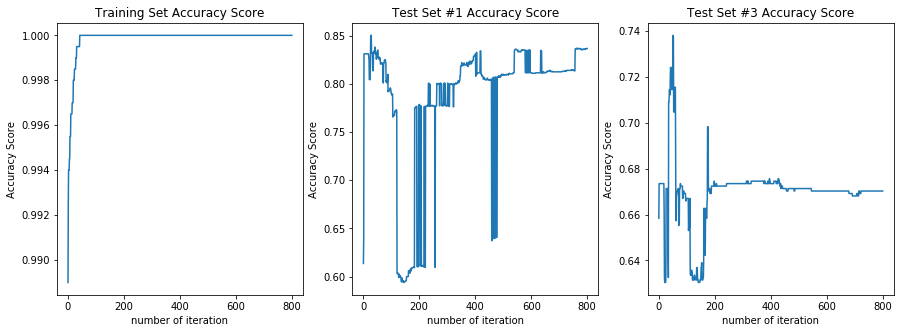

In [94]:
fig, ax = plt.subplots(1,3, figsize = (15,5))

ax[0].plot(np.arange(1, 801, 1), train_staged_score_ada)
ax[0].set_title("Training Set Accuracy Score")
ax[0].set_xlabel("number of iteration")
ax[0].set_ylabel("Accuracy Score")

ax[1].plot(np.arange(1, 801, 1), test_staged_score_1_ada)
ax[1].set_title("Test Set #1 Accuracy Score")
ax[1].set_xlabel("number of iteration")
ax[1].set_ylabel("Accuracy Score")

ax[2].plot(np.arange(1, 801, 1), test_staged_score_3_ada)
ax[2].set_title("Test Set #3 Accuracy Score")
ax[2].set_xlabel("number of iteration")
ax[2].set_ylabel("Accuracy Score")

In [24]:
print('accuracy score of the training set is {}%'.format(train_score_ada))
print('accuracy score of the test set with social spambot #1 is {}%'.format(test_score_1_ada))
print('accuracy score of the test set with social spambot #3 is {}%'.format(test_score_3_ada))

accuracy score of the training set is 100.0%
accuracy score of the test set with social spambot #1 is 88.04238143289606%
accuracy score of the test set with social spambot #3 is 52.90948275862068%


In [25]:
overfit_depth = 100
N = 100

rf_model = RandomForestClassifier(n_estimators = N, criterion='gini', 
                                  max_features='auto', max_depth = overfit_depth, bootstrap=True,
                                 oob_score=True)

rf_model.fit(X_train, y_train)
y_pred_train = rf_model.predict(X_train)

y_pred_test_1 = rf_model.predict(X_test_1)
y_pred_test_3 = rf_model.predict(X_test_3)

train_score = accuracy_score(y_train, y_pred_train) * 100

test_score_1 = accuracy_score(y_test_1, y_pred_test_1) * 100
test_score_3 = accuracy_score(y_test_3, y_pred_test_3) * 100

oobs_score = rf_model.oob_score_

print('accuracy score of the training set is {}%'.format(train_score))
print('accuracy score of the test set with social spambot #1 is {}%'.format(test_score_1))
print('accuracy score of the test set with social spambot #3 is {}%'.format(test_score_3))


C:\Users\motoa\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


accuracy score of the training set is 100.0%
accuracy score of the test set with social spambot #1 is 84.05650857719476%
accuracy score of the test set with social spambot #3 is 77.47844827586206%


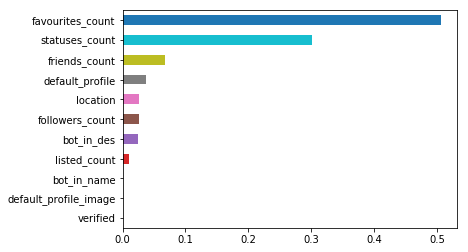

In [26]:
pd.Series(rf_model.feature_importances_,index=list(X_train)).sort_values().plot(kind="barh")

In [27]:
# Multinominal Logistic Regression

log_model = LogisticRegressionCV(fit_intercept=True, cv=5, multi_class="ovr", penalty='l2', max_iter=10000)
log_model.fit(X_train, y_train.values.reshape(-1))

y_pred_train_log = log_model.predict(X_train)

y_pred_test_1_log = log_model.predict(X_test_1)
y_pred_test_3_log = log_model.predict(X_test_3)

train_score_log = accuracy_score(y_train, y_pred_train_log) * 100

test_score_1_log = accuracy_score(y_test_1, y_pred_test_1_log) * 100
test_score_3_log = accuracy_score(y_test_3, y_pred_test_3_log) * 100

print('accuracy score of the training set is {}%'.format(train_score_log))
print('accuracy score of the test set with social spambot #1 is {}%'.format(test_score_1_log))
print('accuracy score of the test set with social spambot #3 is {}%'.format(test_score_3_log))

accuracy score of the training set is 97.55%
accuracy score of the test set with social spambot #1 is 69.02119071644803%
accuracy score of the test set with social spambot #3 is 51.724137931034484%


In [28]:
# K Nearest Neighbours

def normalize (df):
    con_var = ['followers_count', 'listed_count', 'friends_count', 'favourites_count', 'statuses_count']

    for var in con_var:
        x = df[var]
        x = (x - x.mean())/x.std()
        df[var] = x
    
    return df

X_train_norm = normalize(X_train)
X_test_1_norm = normalize(X_test_1)
X_test_3_norm = normalize(X_test_3)

Text(0,0.5,'Mean Accuracy Score')

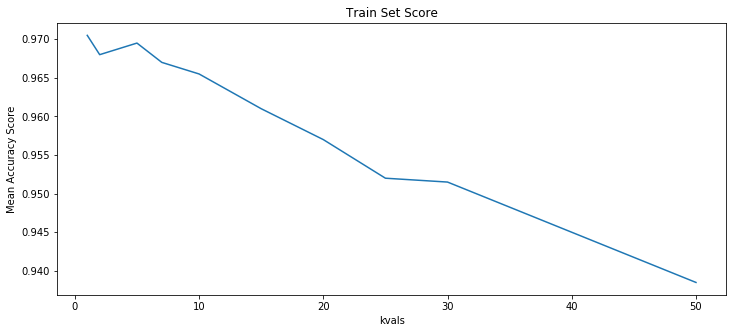

In [29]:
kvals = [1, 2, 5, 7, 10, 15, 20, 25, 30, 50]
knn_score_train = []

for i in kvals:
    model_knn = KNeighborsClassifier(n_neighbors=i, weights = 'uniform')
    train_score = cross_val_score(model_knn, X = X_train_norm, y = y_train.values.reshape(-1), cv=5)
    knn_score_train.append(train_score.mean())

fig, ax = plt.subplots(1,1, figsize = (12,5))

ax.plot(kvals, knn_score_train)
ax.set_title("Train Set Score")
ax.set_xlabel("kvals")
ax.set_ylabel("Mean Accuracy Score")

In [30]:
knn_model = KNeighborsClassifier(n_neighbors=10,weights = 'uniform')
knn_model.fit(X_train, y_train.values.reshape(-1))

y_pred_train_knn = knn_model.predict(X_train)

y_pred_test_1_knn = knn_model.predict(X_test_1)
y_pred_test_3_knn = knn_model.predict(X_test_3)

train_score_knn = accuracy_score(y_train, y_pred_train_knn) * 100

test_score_1_knn = accuracy_score(y_test_1, y_pred_test_1_knn) * 100
test_score_3_knn = accuracy_score(y_test_3, y_pred_test_3_knn) * 100

print('accuracy score of the training set is {}%'.format(train_score_log))
print('accuracy score of the test set with social spambot #1 is {}%'.format(test_score_1_knn))
print('accuracy score of the test set with social spambot #3 is {}%'.format(test_score_3_knn))

accuracy score of the training set is 97.55%
accuracy score of the test set with social spambot #1 is 63.97578203834511%
accuracy score of the test set with social spambot #3 is 68.53448275862068%
